# Purpose of this simulation


## load up the modules


In [21]:
import os
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import numpy as np
import aopy
import sklearn
from weights import *
from weights_linear_regression import calc_R2_with_sim_C
import pickle

# so that we write in latex
from matplotlib import rc
from afs_plotting import subplots_with_labels

rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('paper')
sns.set_theme('paper', font = 'Arial')
sns.set_style('white')


error_bar_method = "sem" #  or percentiles

save_to_gdrive = True # this is done through the gdrive's mapping to the local file system
gdrive_directory = '/home/aolab/gdrive/Projects/Feature Selection/Figures/'

dpi_value = 300

# ideas

In [2]:
# this is for creating exp_conditions that scan the difference across the files
#for comparision
#data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/more_neurons/run_3/'
# data_dump_folder = \
# 'D:/sim_data/gaussian_peaks/2022_02_02_gaussian_peaks/'

data_dump_folder = \
'/home/aolab/sijia/data/figure5_convex_encoder_change/'

ROUND_DECIMALS = 3

n_neurons = 128

# clda setup 
rho = 0.5
batchlen = 100
feature_selection_method = "joint_convex"
encoder_change_mode = "shuffle_rows"
# encoder_change_mode = "change_to_zeros"

# noises = np.arange(9)
# noises = np.exp2(noises)
noises = [32]
noise = 32

# we set up the neural populations
mean_first_peak = 50
mean_second_peak = 100
std_of_peaks = 3


# parameters for smoothe convex optimization
feature_selection_method = "joint_convex"
smoothness_array = np.arange(0.0, 0.15, 0.025) 
sparsity_array = [0.125]
decay_factor_array = [0.2]

smoothness_array = np.array([0, 0.05, 0.1, 0.125])

smoothness_array = np.round(smoothness_array, ROUND_DECIMALS)
smoothnesss_array_parameter_scan = np.round(smoothness_array, ROUND_DECIMALS)

num_lags_array = [3]
num_of_features = 32 # specify how many features we want to use, or None

random_seeds = np.arange(10)
exp_conds = []

for random_seed in random_seeds:
    for sparsity_val in sparsity_array:
        for smoothness_val in smoothness_array:
            for num_lag in num_lags_array:
                for decay_factor in  decay_factor_array:

                        # no one can escape the beauty of python one-liner, granted at the expense of line width
                        sparsity_val, smoothness_val = np.round(sparsity_val, ROUND_DECIMALS), np.round(smoothness_val, ROUND_DECIMALS)
                        

                        exp_conds_wo = [f'{feature_selection_method}_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batchlen}_sparsity_{sparsity_val}_smooth_{smoothness_val}_lags_{num_lag}_decay_{decay_factor}_num_feats_{num_of_features}_{encoder_change_mode}' ]

                        exp_conds.extend(exp_conds_wo)


# feature_selection_schemes = ['Full set', 'Smooth convex selection', 'Lasso selection']
feature_selection_schemes = [ 'Smooth convex selection'] 

NUM_SPARSITY, NUM_SMOOTH = len(sparsity_array), len(smoothness_array)

print("the folder at which data is located:")
print(data_dump_folder)
print(f"we have {len(exp_conds)}" , f"num of sparsity vals {NUM_SPARSITY}", f'num of smoothness vals {NUM_SMOOTH}')
for e in exp_conds:print(e)

the folder at which data is located:
/home/aolab/sijia/data/figure5_convex_encoder_change/
we have 40 num of sparsity vals 1 num of smoothness vals 4
joint_convex_1.0_0_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.125_smooth_0.0_lags_3_decay_0.2_num_feats_32_shuffle_rows
joint_convex_1.0_0_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.125_smooth_0.05_lags_3_decay_0.2_num_feats_32_shuffle_rows
joint_convex_1.0_0_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.125_smooth_0.1_lags_3_decay_0.2_num_feats_32_shuffle_rows
joint_convex_1.0_0_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.125_smooth_0.125_lags_3_decay_0.2_num_feats_32_shuffle_rows
joint_convex_1.0_1_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.125_smooth_0.0_lags_3_decay_0.2_num_feats_32_shuffle_rows
joint_convex_1.0_1_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.125_smooth_0.05_lags_3_decay_0.2_num_feats_32_shuffle_rows
joint_convex_1.0_1_noise_32_128_100_3_clda_rho_0

In [3]:
from afs_files import load_feature_selection_files, load_and_convert_clda_pickle_files
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)
clda_data_all = load_and_convert_clda_pickle_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} number of experiments')



/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 40 number of experiments


# Check feature selection strategies

## check feature weights 

In [4]:
feature_weights = exp_data_all[0]['feature_selection']['feature_weights']
exp_data_all[0]['feature_selection'].keys()
new_sim_c = exp_data_all[0]['feature_selection']['new_sim_c']
sim_C = exp_data_all[0]['feature_selection']['sim_C']

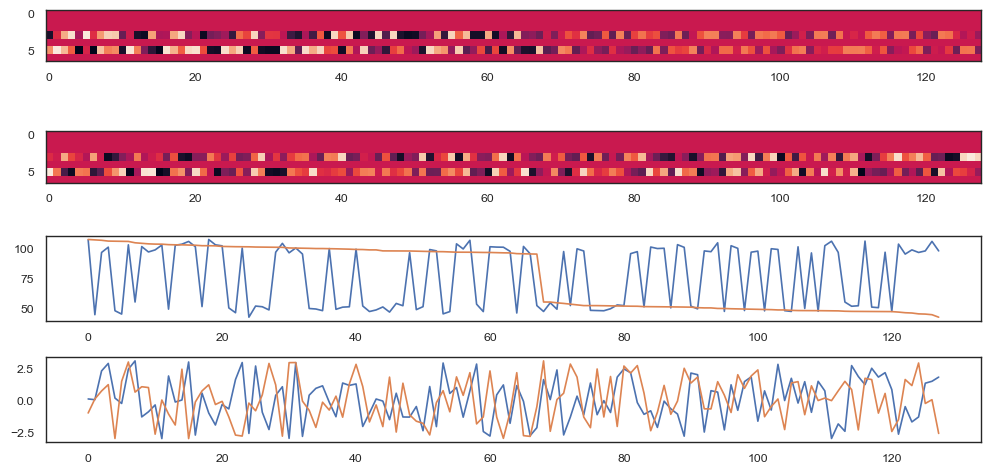

In [5]:
fig, ax = plt.subplots(4, 1, figsize=(10, 5))
ax[0].imshow(sim_C.T)
old_tuning = np.linalg.norm(sim_C, axis=1)
ax[1].imshow(new_sim_c.T)

new_tuning = np.linalg.norm(new_sim_c, axis=1)
ax[2].plot(new_tuning)
ax[2].plot(old_tuning)

ax[3].plot((np.arctan2(new_sim_c[:, 3], new_sim_c[:, 5])))
ax[3].plot((np.arctan2(sim_C[:, 3], sim_C[:, 5])))

fig.tight_layout()


Text(0.5, 1.0, 'Feature distribution std 3 Hz')

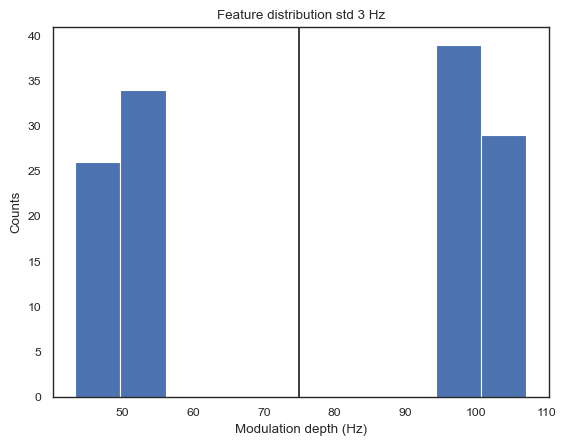

In [6]:
# plot the histogram of the feature weights

std = std_of_peaks

fig_weight, ax_weight = plt.subplots()
ax_weight.hist(feature_weights)
ax_weight.axvline(x = 75, color = 'k')
ax_weight.set_xlabel('Modulation depth (Hz)')
ax_weight.set_ylabel('Counts')
ax_weight.set_title(f'Feature distribution std {std} Hz')

## check between conditions

In [7]:
# calculate encoding truth
from afs_plotting import calculate_encoder_weight_change

new_sim_c = exp_data_all[2]['feature_selection']['new_sim_c']
sim_c = exp_data_all[2]['feature_selection']['sim_C']
encoder_weight_change_shuffle = calculate_encoder_weight_change(sim_c, new_sim_c=new_sim_c,
                                        include_new_sim_c=True, nnum_of_repeats_before=30, num_of_repeats_after=92)

## feature batches

/tmp/ipykernel_3621058/2248401968.py:22: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig_feat_activity.tight_layout()


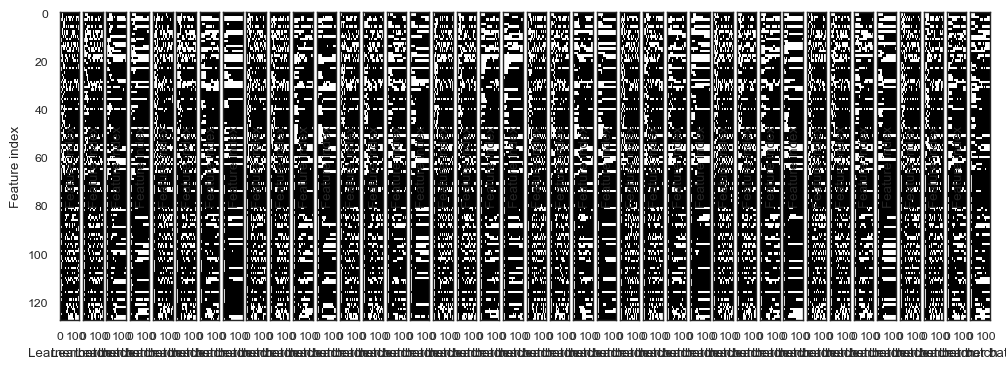

In [8]:
import importlib 
from afs_plotting import plot_feature_selection

if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_feat_activity = plt.subplots(1, num_columns, 
                                                    sharey = True,
                                                    figsize = (12, 4))



    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity)):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        #only title the exp if there are three exp, right. 
        #a.set_title(np.round(s, decimals = ROUND_DECIMALS))

    fig_feat_activity.tight_layout()


In [9]:
# next question I ask,  how many features are being selected, anyway? 
num_features_exp_by_batch = []

selected_feature_batches = [exp_data_all[i]['feature_selection']['feat_set'] for i in range(len(exp_data_all))]

for i,e in enumerate(exp_data_all):

    active_set = e['feature_selection']['feat_set']

    num_features_over_batch = np.sum(active_set, axis = 1)
    num_features_exp_by_batch.append(num_features_over_batch.copy())

num_features_exp_by_batch = np.array(num_features_exp_by_batch)
selected_feature_batches = np.array(selected_feature_batches)

In [10]:
# show_results = False
show_plot_for_one_cond_multiple_seeds = True


selected_features_conds_by_feature_batches = np.moveaxis(selected_feature_batches, 1, 2)


smoothness_conds_by_batch = \
calculate_feature_smoothness_multiple_conditions(selected_features_conds_by_feature_batches, mode = "incremental")

# if the len(smoothness) < len(exp_conds), we reshape and median

if len(smoothness_array) <= len(exp_conds):
    # then we need to do reshape and median
    # assume that len(random_seeds) x len(smooth) = total number of exp
    smoothness_conds_by_batch_reshape = np.reshape(smoothness_conds_by_batch,
                                             (len(random_seeds), len(smoothness_array), -1))
    
        # # after reshape,  we median along the random and first axiss
    print(smoothness_conds_by_batch_reshape.shape)
    smoothness_conds_by_batch_median = np.median(smoothness_conds_by_batch_reshape, axis = 0)

    # calculate the error bars based on the methodßß
    if error_bar_method == "sem":
        smoothness_conds_by_batch_sem = 1.25 * np.std(smoothness_conds_by_batch_reshape, axis = 0) / np.sqrt(len(random_seeds))

        smoothness_conds_by_batch_25 = smoothness_conds_by_batch_median - smoothness_conds_by_batch_sem
        smoothness_conds_by_batch_75 = smoothness_conds_by_batch_median + smoothness_conds_by_batch_sem
        print("used the sem method to calulate the error bar in smoothness")

    elif error_bar_method == "percentiles":
        # also calculate the 25 and 75 percentiles
        smoothness_conds_by_batch_25,  smoothness_conds_by_batch_75 =  \
        np.percentile(smoothness_conds_by_batch_reshape , 
                    [25, 75], 
                    axis = 0)
        print("used the percentiles to calulate the error bar in smoothness")
    else:
        raise ValueError("error bar method not recognized")
    

    # print out a message
    print("we reshaped the smoothness array")

print(smoothness_conds_by_batch.shape)
print(smoothness_conds_by_batch_25.shape)
print(smoothness_conds_by_batch_75.shape)


(10, 4, 121)
used the sem method to calulate the error bar in smoothness
we reshaped the smoothness array
(40, 121)
(4, 121)
(4, 121)


/tmp/ipykernel_3621058/572579485.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sparsity_array)


Text(0.5, 1.0, '')

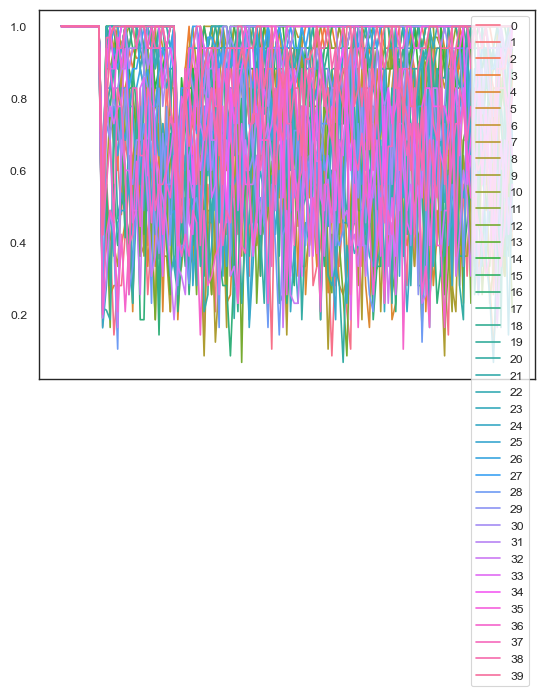

In [11]:
#sns.set_palette("Blues")

ax  = sns.lineplot(data = smoothness_conds_by_batch.T, dashes=False)
ax.set_xticklabels(sparsity_array)
ax.set_title("")

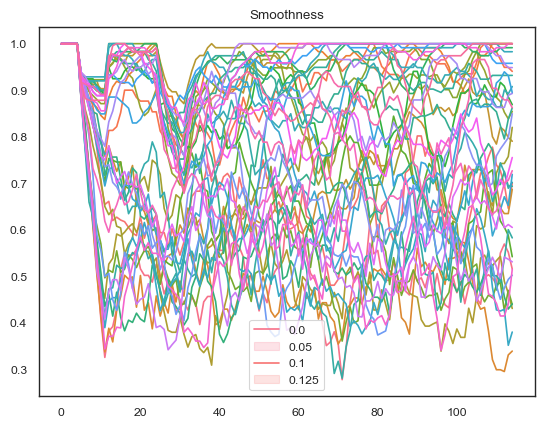

In [12]:

# Assuming smoothness_conds_by_batch is a numpy array with shape (n_batches, n_features)
window_size = 7
weights = np.ones(window_size) / window_size
smoothness_conds_by_batch_ma = np.apply_along_axis(lambda x: np.convolve(x, weights, mode='valid'), 
                                                   axis=1,
                                                   arr=smoothness_conds_by_batch)

ax  = sns.lineplot(data = smoothness_conds_by_batch_ma.T, dashes=False)
# ax.set_xticklabels(sparsity_array)
ax.set_title("Smoothness")
ax.legend(smoothness_array, loc = 'best')


## calculate the relevance

In [13]:
R_2_over_batches_all_exp = []


X_VEL_STATE = 3
Y_VEL_STATE = 5
CONST_STATE = 6

for exp_index in range(len(exp_data_all)):
    # intended_kin = exp_data_all[exp_index]['bmi3d_clda']['intended_kin']
    # spike_counts_batch = exp_data_all[exp_index]['bmi3d_clda']['spike_counts_batch']
    
    try:
        intended_kin = clda_data_all[exp_index]['intended_kin']
        spike_counts_batch = clda_data_all[exp_index]['spike_counts_batch']

        intended_kin = np.array(intended_kin)
        print(intended_kin.shape)

        intended_velocities = intended_kin[:, [X_VEL_STATE, Y_VEL_STATE, CONST_STATE],:]
        # # get C_mat
        feature_selection_data = exp_data_all[exp_index]['feature_selection']
        C_mat = feature_selection_data["C_mat"]
        feat_set = feature_selection_data["feat_set"]

        # # calculate R_2 over batches
        R_2_over_batches = calc_R2_with_sim_C(spike_counts_batch, 
                                            intended_velocities,
                                            C_mat, feat_set, debug = False)
        
        # #save  the results
        R_2_over_batches_all_exp.append(R_2_over_batches)
        
        
    except Exception as e:
        print(f"KeyError: {e}not found in data.")
    
    # #save  the results
    # R_2_over_batches_all_exp.append(R_2_over_batches)
    
    print(exp_index)
    
R_2_over_batches_all_exp = np.array(R_2_over_batches_all_exp)
R_2_over_batches_all_exp_gap = R_2_over_batches_all_exp.T

(120, 7, 100)
0
(120, 7, 100)
1
(120, 7, 100)
2
(120, 7, 100)
3
(120, 7, 100)
4
(120, 7, 100)
5
(120, 7, 100)
6
(120, 7, 100)
7
(120, 7, 100)
8
(120, 7, 100)
9
(120, 7, 100)
10
(120, 7, 100)
11
(120, 7, 100)
12
(120, 7, 100)
13
(120, 7, 100)
14
(120, 7, 100)
15
(120, 7, 100)
16
(120, 7, 100)
17
(120, 7, 100)
18
(120, 7, 100)
19
(120, 7, 100)
20
(120, 7, 100)
21
(120, 7, 100)
22
(120, 7, 100)
23
(120, 7, 100)
24
(120, 7, 100)
25
(120, 7, 100)
26
(120, 7, 100)
27
(120, 7, 100)
28
(120, 7, 100)
29
(120, 7, 100)
30
(120, 7, 100)
31
(120, 7, 100)
32
(120, 7, 100)
33
(120, 7, 100)
34
(120, 7, 100)
35
(120, 7, 100)
36
(120, 7, 100)
37
(120, 7, 100)
38
(120, 7, 100)
39


In [14]:
# apply moving average to the first axis
window_size = 6
weights = np.ones(window_size) / window_size
R_2_over_batches_all_exp_gap_ma = np.apply_along_axis(lambda x: np.convolve(x, weights, mode='valid'), 
                                                   axis=0,
                                                   arr=R_2_over_batches_all_exp_gap)


# Behaviour comparision

## count how many rewards

In [16]:
fps = 60
show_plot_for_one_cond_multiple_seeds = False
reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

total_rewards_all = list()

for i in range(NUM_EXP):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']
    
    
    num_rewards = np.count_nonzero(events == b'REWARD')

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    reward_rate_all.append(reward_rate)
    window_time_stamps_all.append(window_time_stamps)
    total_rewards_all.append(num_rewards)



window_stamps_all = np.array(window_time_stamps_all)
reward_rate_all = np.array(reward_rate_all) 
reward_rate_all = reward_rate_all.reshape((NUM_EXP,-1))
window_stamps_all = window_stamps_all.reshape((NUM_EXP,-1))

reward_rate_for_test = np.copy(reward_rate_all)

# if the len(smoothness) < len(exp_conds), we reshape and median
if len(smoothness_array) < len(exp_conds):
    # then we need to do reshape and median
    # assume that len(random_seeds) x len(smooth) = total number of exp
    reward_rate_all_reshape = np.reshape(reward_rate_all,
                    (len(random_seeds), len(smoothness_array), -1))

    # plot random seeds for one condition
    if show_plot_for_one_cond_multiple_seeds:
        plt.plot(reward_rate_all[:, 0, :].T)

    # calculate the median across the random seeds, and the 25th, 75th percentiles
    # calculate the median across the random seeds
    reward_rate_all_median = np.median(reward_rate_all_reshape, axis = 0)

    # calculate the error bars based on the error_bar_method
    if error_bar_method == "sem":
        reward_rate_all_sem = 1.25 * np.std(reward_rate_all_reshape, axis = 0) / np.sqrt(len(random_seeds))
        reward_rate_all_25 = reward_rate_all_median - reward_rate_all_sem
        reward_rate_all_75 = reward_rate_all_median + reward_rate_all_sem
        print("used the sem method")
    elif error_bar_method == "percentiles":
        reward_rate_all_25, reward_rate_all_75 = np.percentile(reward_rate_all_reshape, [25, 75], axis = 0)
        print("used the percentiles method")
    
    # # after reshape,  we median along the random and first axiss
    reward_rate_all = np.median(reward_rate_all_reshape, axis = 0)

    # print out a message
    print("we reshaped the reward rate array")

total_rewards_all = np.array(total_rewards_all)

print(reward_rate_all.shape)
print(reward_rate_all_25.shape)
print(reward_rate_all_75.shape)

used the sem method
we reshaped the reward rate array
(4, 36)
(4, 36)
(4, 36)


## statistical tests on the reward rate

In [33]:
from statsmodels.stats.anova import AnovaRM

window_stamps_one_trial = window_stamps_all[0]
last_minutes = 5 * 60
reward_rate_all_last_5_min = reward_rate_for_test[:, 
                                             window_stamps_one_trial > (window_stamps_one_trial[-1] - last_minutes)]

reward_rate_all_last_5_min = np.mean(reward_rate_all_last_5_min, axis = 1)

# formulate into a pandas data frame for annovaRM test

df_long = pd.DataFrame(
    {
        'reward_rate': reward_rate_all_last_5_min,
        'smoothness': np.tile(smoothness_array, len(random_seeds)),
        'random_seed': np.repeat(random_seeds, len(smoothness_array))
    }
)

# Perform repeated measures ANOVA
aovrm = AnovaRM(data=df_long, 
                depvar='reward_rate', subject='random_seed', 
                within=['smoothness'])
result = aovrm.fit()

# Access the ANOVA table
anova_table = result.anova_table

# Print the exact p-value
exact_p_value = anova_table["Pr > F"]["smoothness"]
print(f'Exact p-value: {exact_p_value}')


Exact p-value: 4.568512608527567e-13


Text(0, 0.5, 'Reward Rate')

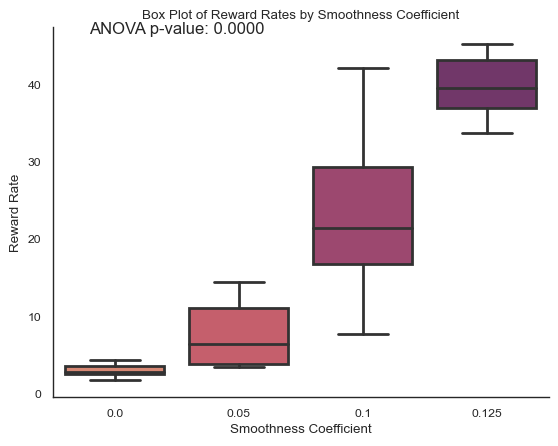

In [40]:
## plot the reward rate
colors = sns.color_palette('flare', n_colors=len(smoothness_array))
box = sns.boxplot(x='smoothness', y='reward_rate', data=df_long,
                  palette=colors, linewidth=2)


# Add p-value text to the plot
plt.text(x=0.5, y=max(df_long['reward_rate']) + 1, s=f'ANOVA p-value: {exact_p_value:.4f}', 
         ha='center', va='bottom', fontsize=12)


# remove the top and right spines
sns.despine()

# Add title and labels
plt.title('Box Plot of Reward Rates by Smoothness Coefficient')
plt.xlabel('Smoothness Coefficient')
plt.ylabel('Reward Rate')


# Include the results from the stationary encoder

In [17]:
ROUND_DECIMALS = 3


data_dump_folder = \
'/home/aolab/sijia/data/figure4_convex_stationary_encoder/'
random_seed = 0
n_neurons = 128
# 
mean_first_peak = 50
mean_second_peak = 100
std = 3
ENCODER_CHANGE_MODE = "same"

# clda setup 
rho = 0.5
batchlen = 100

# noises = np.arange(9)
# noises = np.exp2(noises)
noises = [32]
noise = 32

smoothness_coef = 0.1
num_of_lags = 3#  this is the K in the formulation, the number of batch updated feature scores we expect it to be.
past_batch_decay_factor = 0.2


exp_conds = []

sparsity_array = [0.06]
smoothness_array = [0.0, 0.125]

sparsity_array = np.round(sparsity_array, ROUND_DECIMALS)
smoothness_array = np.round(smoothness_array, ROUND_DECIMALS)

num_of_features_array  = [32]   # specify how many features we want to use, or None
#TODO: add 32 to that number of features array

for sparsity_val in sparsity_array:
    for smoothness_val in smoothness_array:
        for num_of_features in num_of_features_array:
            exp_conds_add = [f'joint_convex_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std}_clda_rho_{rho}_batchlen_{batchlen}_sparsity_{sparsity_val}_smooth_{smoothness_val}_lags_{num_of_lags}_decay_{past_batch_decay_factor}_num_feats_{num_of_features}_{ENCODER_CHANGE_MODE}' ]
            exp_conds.extend(exp_conds_add)
        #exp_conds.extend(exp_conds_keep)

NUM_SPARSITY, NUM_SMOOTH = len(sparsity_array), len(smoothness_array)

print("the folder at which data is located:")
print(data_dump_folder)
print(f"we have {len(exp_conds)}" , f"num of sparsity vals {NUM_SPARSITY}", f'num of smoothness vals {NUM_SMOOTH}')


for e in exp_conds: print(e)

the folder at which data is located:
/home/aolab/sijia/data/figure4_convex_stationary_encoder/
we have 2 num of sparsity vals 1 num of smoothness vals 2
joint_convex_1.0_0_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.06_smooth_0.0_lags_3_decay_0.2_num_feats_32_same
joint_convex_1.0_0_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.06_smooth_0.125_lags_3_decay_0.2_num_feats_32_same


In [18]:
(exp_data_all_stationary, exp_metadata_all_stationary) = load_feature_selection_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all_stationary)} number of experiments')

/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 2 number of experiments


## calculate the encoder change

In [19]:
new_sim_c = exp_data_all_stationary[0]['feature_selection']['new_sim_c']
sim_c = exp_data_all_stationary[0]['feature_selection']['sim_C']
encoder_weight_change_stationary = calculate_encoder_weight_change(sim_c, new_sim_c=new_sim_c,
                                        include_new_sim_c=True, nnum_of_repeats_before=30, num_of_repeats_after=92)

In [20]:
import pickle
# this is loaded from 231019_afs_grid_random_start_smoothness_sparsity
# load the pickle file for the stationary encoder
with open(data_dump_folder + 'smooth_and_reward_dict_stationary.pkl', 'rb') as f:
    smooth_and_reward_dict = pickle.load(f)

print("smooth_and_reward_dict.keys():")
for k in smooth_and_reward_dict.keys(): print(k)

# get the smoothness and the 25th and 75th percentiles
# note that the 25th and 75h percentiles are sem,  convenience for plotting
smoothness_array = smooth_and_reward_dict['smoothness_array']
smoothness_conds_by_batch_stationary = smooth_and_reward_dict['smoothness_conds_by_batch']  
smoothness_conds_by_batch_25_stationary = smooth_and_reward_dict['smoothness_conds_by_batch_25']
smoothness_conds_by_batch_75_stationary = smooth_and_reward_dict['smoothness_conds_by_batch_75']


# also need the 25th and 75th percentiles of the reward rates 
reward_rate_all_stationary = smooth_and_reward_dict['reward_rate_all']
reward_rate_all_25_stationary = smooth_and_reward_dict['reward_rate_all_25']
reward_rate_all_75_stationary = smooth_and_reward_dict['reward_rate_all_75']

smooth_and_reward_dict.keys():
smoothness_array
smoothness_conds_by_batch
smoothness_conds_by_batch_25
smoothness_conds_by_batch_75
reward_rate_all
reward_rate_all_25
reward_rate_all_75


## load decoder and encoder error plot

In [21]:
# load the encoder_decoder_box_plot data

with open(data_dump_folder + 'encoder_decoder_box_plot_data.pkl', 'rb') as f:
    box_plot_data = pickle.load(f)
    active_angles_all = box_plot_data['active_angles_all']
    active_angles_all_top = box_plot_data['active_angles_all_top']
    active_angles_all_bottom = box_plot_data['active_angles_all_bottom']
    smoothness_array_box_plot =  box_plot_data['smoothness_array']
    skipped = box_plot_data['n_skipped']


Text(0, 0.5, 'Encoder-Decoder Error')

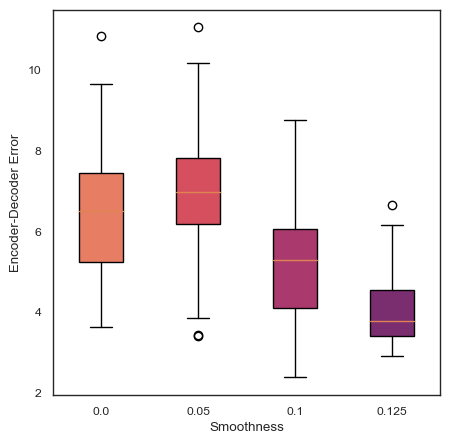

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

colors = sns.color_palette('flare', n_colors=len(smoothness_array))


box = ax.boxplot(active_angles_all[:, skipped:].T, 
                 patch_artist=True)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(smoothness_array)
ax.set_xlabel('Smoothness')
ax.set_ylabel('Encoder-Decoder Error')


## make a summary figure

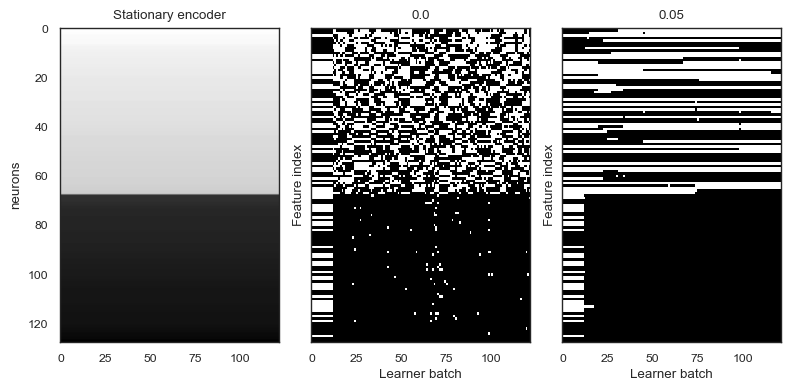

In [23]:
num_columns = len(exp_data_all_stationary) + 1

fig_feat_activity, ax_feat_activity = plt.subplots(1,num_columns, 
                                                   sharey = True,
                                                   figsize = (8, 4))

# the first figure is the stationary encoder
# then the shuffling encoder case
ax_feat_activity[0].imshow(encoder_weight_change_stationary, cmap = 'gray',
                                          aspect = 'auto')
ax_feat_activity[0].grid(False)
ax_feat_activity[0].set_ylabel('neurons')
ax_feat_activity[0].set_title('Stationary encoder')


for i, (e, a, s) in enumerate(zip(exp_data_all_stationary,  
                                ax_feat_activity[1:], smoothness_array)):
    plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
    
    #only title the exp if there are three exp, right. 
    a.set_title(np.round(s, decimals = ROUND_DECIMALS))

fig_feat_activity.tight_layout()


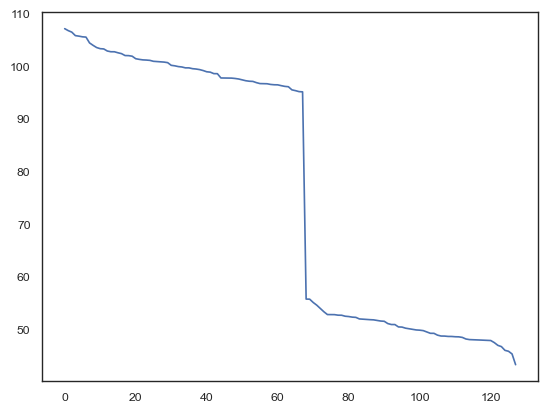

In [24]:
plt.plot(encoder_weight_change_stationary[:,59])

# Make a summary figure

In [25]:
def concatenate_encoder_weights_feature_sets(encoder_weight, exp_data):
    num_batches = encoder_weight.shape[0]

    num_blank_columns = 5
    blank_columns = np.ones((num_blank_columns, encoder_weight.shape[0]))

    feature_sets_one_cond = exp_data[0]['feature_selection']['feat_set']
    feature_sets_the_other_cond = exp_data[-1]['feature_selection']['feat_set']
    # make these numpy arrays
    feature_sets_one_cond = np.array(feature_sets_one_cond)
    feature_sets_the_other_cond = np.array(feature_sets_the_other_cond)
    # concatenate the feature sets along the second axis
    feature_sets = np.concatenate((feature_sets_one_cond, blank_columns, feature_sets_the_other_cond), axis=0)

    # add the encoder weights to the feature sets
    encoder_weights = encoder_weight.T
    # normalize to 0 and 1
    encoder_weights = (encoder_weights - encoder_weights.min()) / (encoder_weights.max() - encoder_weights.min())

    encoder_weights_feature_sets = np.concatenate((encoder_weights, blank_columns, feature_sets), axis=0)

    # make columns are neurons and rows are selections
    encoder_weights_feature_sets = encoder_weights_feature_sets.T


    return encoder_weights_feature_sets

num_batches = encoder_weight_change_stationary.shape[0]

# Usage example:
encoder_weights_feature_sets_stationary = concatenate_encoder_weights_feature_sets(encoder_weight_change_stationary, 
                                                                        exp_data_all_stationary)

encoder_weights_feature_sets_shuffle = concatenate_encoder_weights_feature_sets(encoder_weight_change_shuffle,
                                                                        exp_data_all)   

print(encoder_weights_feature_sets_stationary.shape)
print(encoder_weights_feature_sets_shuffle.shape)

(128, 376)
(128, 376)


Text(0.5, 0, 'Time (min)')

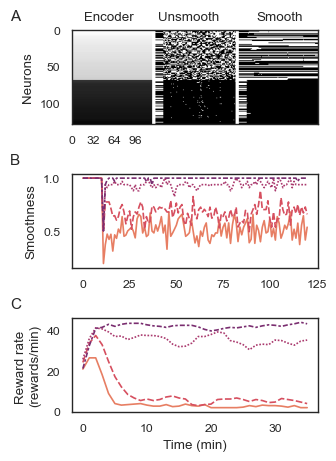

In [26]:
# for one encoder condition, make a column plot, then we can align afterwards
delta_batch_for_display = 32


summary_figure, summary_axes = subplots_with_labels(3, 1, figsize = (3.25, 4.5))

# the first row is the stationary encoder
ax_feat_activity = summary_axes[0,0]

ax_feat_activity.imshow(encoder_weights_feature_sets_stationary, cmap = 'gray',
                                          aspect = 'auto')

# only label the first 125 columns
ax_feat_activity.set_xticks(np.arange(0, num_batches, delta_batch_for_display))
ax_feat_activity.set_xticklabels(np.arange(0, num_batches, delta_batch_for_display ))

ax_feat_activity.grid(False)
ax_feat_activity.set_ylabel('Neurons')
# ax_feat_activity.set_title('Stationary')

# put three texts  encoder, smooth, unsmooth on top of the first row, evenly spaced
ax_feat_activity.text(0.05, 1.1, 'Encoder', transform=ax_feat_activity.transAxes)
ax_feat_activity.text(0.35, 1.1, 'Unsmooth', transform=ax_feat_activity.transAxes)
ax_feat_activity.text(0.75, 1.1, 'Smooth', transform=ax_feat_activity.transAxes)


sns.lineplot(data=smoothness_conds_by_batch_stationary.T, 
             palette=colors, 
             ax=summary_axes[1,0], 
             legend=False)
summary_axes[1,0].set_ylabel('Smoothness')

sns.lineplot(data=reward_rate_all_stationary.T, 
             palette=colors, 
             ax=summary_axes[2,0],
             legend=False)
summary_axes[2,0].set_ylabel('Reward rate \n(rewards/min)')
summary_axes[2,0].set_xlabel('Time (min)')


### load up the oracle results


In [27]:
## load up the oracle feature selection results

oracle_data_dump_folder = \
    '/home/aolab/sijia/data/figure2_simulation_setup/'
# we load the oracle_data_dict from the oracle_data_dump_folder

with open(os.path.join(oracle_data_dump_folder,
                       'oracle_data_dict.pkl'), 'rb') as f:
    oracle_data_dict = pickle.load(f)

# load the data from the oracle_data_dict
oracle_reward_rate = oracle_data_dict['reward_rate_all']
oracle_window_stamps_all = oracle_data_dict['window_stamps_all']
oracle_smoothness_conds_by_batch = \
    oracle_data_dict['smoothness_conds_by_batch']

### PLOT: new columns

(4, 2)


/tmp/ipykernel_3614586/3177378846.py:178: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('flare', num_colors)
/tmp/ipykernel_3614586/3177378846.py:191: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(smoothnesss_array_parameter_scan)


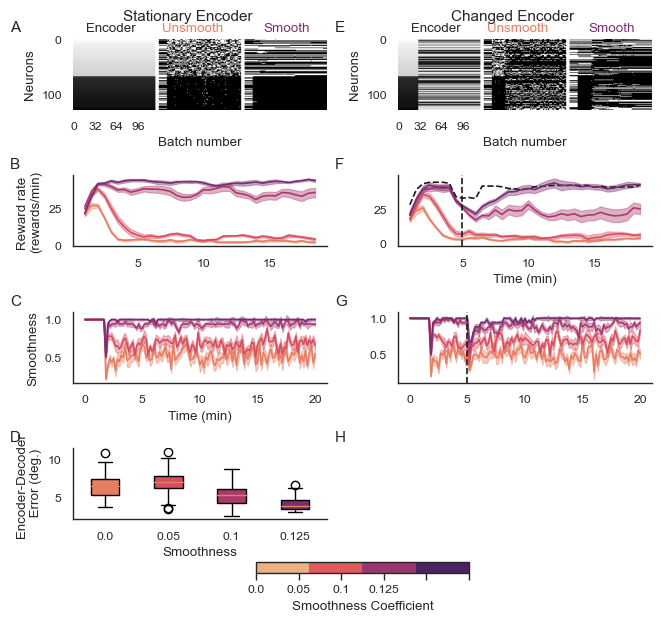

In [28]:
summary_figure, summary_axes_stationary_left_shuffling_right = subplots_with_labels(4, 2, figsize = (6.5, 6.0), 
                                                    label_directions='col_first')

alpha_value = 0.4
print(summary_axes_stationary_left_shuffling_right.shape)
summary_axes  = summary_axes_stationary_left_shuffling_right[:,0][:, np.newaxis]

smoothness_xlabels =  np.arange(0, smoothness_conds_by_batch.shape[1]) / 6 # 10 batches per minute 
encoder_weight_labels =  np.arange(0, num_batches, delta_batch_for_display ) / 6
# convert encoder weight labels to integer
encoder_weight_labels = np.rint(encoder_weight_labels).astype(int)


# the first row is the stationary encoder
ax_feat_activity = summary_axes[0,0]

ax_feat_activity.imshow(encoder_weights_feature_sets_stationary, cmap = 'gray',
                                          aspect = 'auto')

# only label the first 125 columns
ax_feat_activity.set_xticks(np.arange(0, num_batches, delta_batch_for_display))
ax_feat_activity.set_xticklabels(np.arange(0, num_batches, delta_batch_for_display ))
label = ax_feat_activity.set_xlabel('Batch number' )



ax_feat_activity.set_ylabel('Neurons')
# ax_feat_activity.set_title('Stationary')

# add a horizontal line above the first axis to indicate stationary encoder
lgd_text = summary_figure.text(0.28, 1, 'Stationary Encoder', ha='center', va='center', fontsize=11)
lgd_text2 = summary_figure.text(0.78, 1, 'Changed Encoder', ha='center', va='center', fontsize=11)

# ax_feat_activity.axhline(y=256, color='k', linestyle='--')

# put three texts  encoder, smooth, unsmooth on top of the first row, evenly spaced
ax_feat_activity.text(0.05, 1.1, 'Encoder', transform=ax_feat_activity.transAxes)
ax_feat_activity.text(0.35, 1.1, 'Unsmooth', transform=ax_feat_activity.transAxes, color=colors[0])
ax_feat_activity.text(0.75, 1.1, 'Smooth', transform=ax_feat_activity.transAxes, color = colors[-1])

# build the color wheel
colors = sns.color_palette('flare', n_colors=len(smoothnesss_array_parameter_scan))
norm = plt.Normalize(smoothnesss_array_parameter_scan.min(), 
                     smoothnesss_array_parameter_scan.max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)

# stationary encoder case, plot the feature selection results
# add the error bars using a for loop
ax = summary_axes[2,0]
for i, s in enumerate(smoothness_array):
    ax.plot(smoothness_xlabels, smoothness_conds_by_batch_stationary[i], 
            color=colors[i])
    ax.fill_between(smoothness_xlabels, 
                                   smoothness_conds_by_batch_25_stationary[i], 
                                   smoothness_conds_by_batch_75_stationary[i], 
                                   color=colors[i], 
                                   alpha=alpha_value)
ax.set_ylabel('Smoothness')
ax.set_xlabel('Time (min)')

# stationary encoder, plot the reward rate
# add the error bars using a for loop
ax = summary_axes[1,0]
for i, s in enumerate(smoothness_array):
    ax.plot(window_time_stamps / 60, 
                reward_rate_all_stationary[i], color=colors[i])
    ax.fill_between(window_time_stamps / 60, 
                                   reward_rate_all_25_stationary[i], 
                                   reward_rate_all_75_stationary[i], 
                                   color=colors[i], 
                                   alpha=alpha_value)

ax.set_ylabel('Reward rate \n(rewards/min)')
# turn off x axis labels

# last figure is actually the encoder and decoder error

ax = summary_axes[3,0]
box = ax.boxplot(active_angles_all[:, skipped:].T,
                    patch_artist=True)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Encoder-Decoder \n Error (deg.)')
ax.set_xticklabels(smoothness_array)
ax.set_xlabel('Smoothness')


###################################################################
# the second column is the changed encoder 

summary_axes  = summary_axes_stationary_left_shuffling_right[:,1][:, np.newaxis]


# the first row is the stationary encoder
ax_feat_activity = summary_axes[0,0]

ax_feat_activity.imshow(encoder_weights_feature_sets_shuffle, cmap = 'gray',
                                          aspect = 'auto')

# only label the first 125 columns
ax_feat_activity.set_xticks(np.arange(0, num_batches, delta_batch_for_display))
ax_feat_activity.set_xticklabels(np.arange(0, num_batches, delta_batch_for_display ))

ax_feat_activity.grid(False)
ax_feat_activity.set_ylabel('Neurons')
# ax_feat_activity.set_title('Stationary')
label = ax_feat_activity.set_xlabel('Batch number' )


# put three texts  encoder, smooth, unsmooth on top of the first row, evenly spaced
ax_feat_activity.text(0.05, 1.1, 'Encoder', transform=ax_feat_activity.transAxes)
ax_feat_activity.text(0.35, 1.1, 'Unsmooth', color = colors[0],
                      transform=ax_feat_activity.transAxes)
ax_feat_activity.text(0.75, 1.1, 'Smooth', color = colors[-1],
                      transform=ax_feat_activity.transAxes)

# # shuffling encoder case, plot the feature selection results
# sns.lineplot(data=smoothness_conds_by_batch_median, 
#              palette=colors, 
#              ax=summary_axes[1,0], 
#              linestyle = 'solid',
#              legend=False)
# add the error bars using a for loop
ax = summary_axes[2,0]
for i, s in enumerate(smoothness_array):
    ax.plot(smoothness_xlabels, smoothness_conds_by_batch_median[i], color=colors[i])
    ax.fill_between(smoothness_xlabels, 
                                   smoothness_conds_by_batch_25[i], 
                                   smoothness_conds_by_batch_75[i], 
                                   color=colors[i], 
                                   alpha=alpha_value)
ax.axvline(x=5, color='k', linestyle='--')

# summary_axes[1,0].set_ylabel('Smoothness')
# shuffling encoder, plot the reward rate
# add a dotted line to indicate encoder swap

ax = summary_axes[1,0]

# add the oracle reward rate
ax.plot(window_time_stamps / 60, 
        oracle_reward_rate[0], label = "Oracle",
        color = 'k', linestyle = '--')

# add the error bars using a for loop
for i, s in enumerate(smoothness_array):
    ax.plot(window_time_stamps / 60, reward_rate_all[i], color=colors[i])
    ax.fill_between(window_time_stamps / 60, 
                                   reward_rate_all_25[i], 
                                   reward_rate_all_75[i], 
                                   color=colors[i], alpha=0.4)
ax.set_xlabel('Time (min)')
ax.axvline(x=5, color='k', linestyle='--')

# delete the very last eaxis
summary_axes_stationary_left_shuffling_right[3,1].axis('off')

# add a colorbar below the figure
norm = plt.Normalize(smoothnesss_array_parameter_scan.min(), 
                     smoothnesss_array_parameter_scan.max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)



# remove the top and right spines for all axes
for ax in summary_axes_stationary_left_shuffling_right.flatten():
    # for the first and 4th ax, also remove the left spine and the bottom spine
    if ax == summary_axes_stationary_left_shuffling_right[0,0] or ax == summary_axes_stationary_left_shuffling_right[0,1]:
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# create a discrete colormap
num_colors = len(smoothnesss_array_parameter_scan)
cmap = plt.cm.get_cmap('flare', num_colors)
cmap_discrete = plt.cm.colors.ListedColormap(cmap(np.arange(num_colors)))

# build the color wheel
norm = plt.Normalize(smoothnesss_array_parameter_scan.min(), smoothnesss_array_parameter_scan.max())
sm = plt.cm.ScalarMappable(cmap=cmap_discrete, norm=norm)

# create the colorbar
cbar = summary_figure.colorbar(sm, ax=summary_axes_stationary_left_shuffling_right[3], 
                               orientation='horizontal', location="bottom")
cbar.set_label('Smoothness Coefficient')

# Set the colorbar ticks to smoothness_color_scan
cbar.set_ticklabels(smoothnesss_array_parameter_scan)






In [29]:
# save the plotting data
plotting_data = dict()
plotting_data['encoder_weights_feature_sets_stationary'] = encoder_weights_feature_sets_stationary
plotting_data['encoder_weights_feature_sets_shuffle'] = encoder_weights_feature_sets_shuffle
plotting_data['smoothness_conds_by_batch_stationary'] = smoothness_conds_by_batch_stationary
plotting_data['smoothness_conds_by_batch_25_stationary'] = smoothness_conds_by_batch_25_stationary
plotting_data['smoothness_conds_by_batch_75_stationary'] = smoothness_conds_by_batch_75_stationary  
plotting_data['reward_rate_all_stationary'] = reward_rate_all_stationary    
plotting_data['reward_rate_all_25_stationary'] = reward_rate_all_25_stationary
plotting_data['reward_rate_all_75_stationary'] = reward_rate_all_75_stationary
plotting_data['smoothness_array'] = smoothness_array
plotting_data['smoothnesss_array_parameter_scan'] = smoothnesss_array_parameter_scan
plotting_data['window_time_stamps'] = window_time_stamps  
plotting_data['num_batches'] = num_batches
plotting_data['active_angles_all'] = active_angles_all


# save the plotting data
with open(data_dump_folder + 'plotting_data.pkl', 'wb') as f:
    pickle.dump(plotting_data, f)

### gdrive

In [30]:
if save_to_gdrive:
    summary_figure.savefig(gdrive_directory + 'figure5_smooth_encoder_change.pdf', dpi=dpi_value,
                           bbox_extra_artists=(lgd_text, lgd_text2,), bbox_inches='tight')
    summary_figure.savefig(gdrive_directory + 'figure5_smooth_encoder_change.png', dpi=dpi_value,
                           bbox_extra_artists=(lgd_text, lgd_text2,), bbox_inches='tight')
    summary_figure.savefig(gdrive_directory + 'figure5_smooth_encoder_change.svg', dpi=dpi_value, 
                           bbox_extra_artists=(lgd_text, lgd_text2,), bbox_inches='tight')
